In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import pandas as pd
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Install required packages
!pip install langdetect
!pip install nltk
!pip install sbnltk
!pip install textblob
!pip install imblearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 12.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993223 sha256=16617d4ef9ade3b8475315422f28dd7dd1b2b29efc104013db976d29436d1fad
  Stored in directory: /root/.cache/pip/wheels/0a/f2/b2/e5ca405801e05eb7c8ed5b3b4bcf1fcabcd6272c167640072e
Successfully built langdetect
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.8/123.8 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 95.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8

In [5]:
# Import text processing libraries
import pandas as pd
import re
import string
from langdetect import detect
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
from sbnltk.Stemmer import stemmerOP
from sbnltk.Preprocessor import preprocessor
from sbnltk.Tokenizer import wordTokenizer, sentenceTokenizer
from textblob import TextBlob
from imblearn.over_sampling import SMOTE  # Add SMOTE for handling imbalanced classes

Downloading...
From: https://drive.google.com/uc?id=142XvJg9xdpgzuYD31Y4pm-ZVdMaWmtuq
To: /usr/local/lib/python3.11/dist-packages/sbnltk/dataset/download_link.txt
100%|██████████| 1.66k/1.66k [00:00<00:00, 4.73MB/s]
Downloading...
From: https://drive.google.com/uc?id=1UIR2arP_6Fm0MqJVbcG2Q9iLCnjQriDB
To: /usr/local/lib/python3.11/dist-packages/sbnltk/dataset/bangla_word_list.txt
100%|██████████| 15.4M/15.4M [00:00<00:00, 40.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1e4x5FQrdGyEfBBzQ_DOJ9wBxZZ1F7bx7
To: /usr/local/lib/python3.11/dist-packages/sbnltk/dataset/stopword_list.txt
100%|██████████| 4.77k/4.77k [00:00<00:00, 12.3MB/s]


In [6]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter

In [7]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [8]:
# Load data
df = pd.read_excel('/content/drive/MyDrive/TechTalentAssignment/Data & Topics.xlsx')
df.drop_duplicates(inplace=True)
print(f"Dataset shape after removing duplicates: {df.shape}")

Dataset shape after removing duplicates: (551, 3)


In [9]:
# Define text processing functions
# Emoji removal pattern
emoji_pattern = re.compile(
    "["
    u"\U0001F600-\U0001F64F"  # Emoticons
    u"\U0001F300-\U0001F5FF"  # Symbols & Pictographs
    u"\U0001F680-\U0001F6FF"  # Transport & Map
    u"\U0001F1E0-\U0001F1FF"  # Flags
    u"\U00002700-\U000027BF"  # Dingbats
    u"\U0001F900-\U0001F9FF"  # Supplemental symbols
    u"\U0001FA70-\U0001FAFF"  # Extended-A (🫵)
    u"\U00002600-\U000026FF"  # Misc symbols
    u"\U0001F000-\U0001F02F"  # Mahjong
    u"\U0000203C"             # Double exclamation
    u"\uFE0F"                 # Variation Selector-16
    "]+",
    flags=re.UNICODE
)

# Custom punctuation (Bangla, Urdu, Arabic)
custom_punct = '।॥''""…،؛؟'
all_punct = string.punctuation + custom_punct

# Load stopwords
en_stop = set(stopwords.words('english'))

# Initialize processors
en_lem = WordNetLemmatizer()
bn_preprocessor = preprocessor()
bn_word_tokenizer = wordTokenizer()
bn_stemmer = stemmerOP()

# Detect Bengali characters
def is_bengali(word):
    return bool(re.search(r'[\u0980-\u09FF]', word))

# Clean and preprocess text
def preprocess_text(text):
    text = str(text)

    # Remove URLs, hashtags, mentions
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"#\w+", "", text)
    text = re.sub(r"@\w+", "", text)

    # Remove emojis
    text = emoji_pattern.sub('', text)

    # Remove punctuations
    text = re.sub(f"[{re.escape(all_punct)}]", "", text)

    # Normalize space
    text = re.sub(r'\s+', ' ', text).strip()

    try:
        lang = detect(text)
    except:
        lang = 'en'

    # For Bengali text, use SBNLTK tokenizer
    if (lang == 'bn'):
        try:
            text = bn_preprocessor.word_normalize(text)
            # Tokenize into words
            tokens = bn_word_tokenizer.basic_tokenizer(text)

            # Apply stemming to each token
            tokens = [bn_stemmer.stemWord(t) for t in tokens]
            # Apply dust remove to each token
            tokens = [bn_preprocessor.dust_removal(t) for t in tokens]
        except:
            # Fallback to NLTK if SBNLTK fails
            tokens = word_tokenize(text)
            tokens = [t.lower() for t in tokens if t.isalpha()]
    else:
        # For English, use NLTK with TextBlob correction
        try:
            textBlb = TextBlob(text)
            textBlb = textBlb.correct()
            text = textBlb.string
        except:
            # If TextBlob correction fails
            pass

        # Tokenize into words
        tokens = word_tokenize(text)
        tokens = [t.lower() for t in tokens if t.isalpha()]

    clean_tokens = []
    for token in tokens:
        if is_bengali(token):
            # Bengali tokens are already preprocessed and stemmed
            clean_tokens.append(token)
        else:
            if token not in en_stop:
                lemma = en_lem.lemmatize(token)
                clean_tokens.append(lemma)

    return ' '.join(clean_tokens)  # Return as space-separated string for TF-IDF

Downloading...
From: https://drive.google.com/uc?id=1ohRYMGAeq4RZTa3W-7DXEsaUCaVNIxgO
To: /usr/local/lib/python3.11/dist-packages/sbnltk/dataset/rootword_list.txt
100%|██████████| 2.00M/2.00M [00:00<00:00, 66.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1oBEK2DUs6Jt155AmMyc9565dHJJFZd_N
To: /usr/local/lib/python3.11/dist-packages/sbnltk/dataset/ner_static.txt
100%|██████████| 20.2M/20.2M [00:00<00:00, 62.6MB/s]


In [10]:
# Apply preprocessing to data
print("Applying text preprocessing...")
df['clean_context'] = df['Context'].apply(preprocess_text)

Applying text preprocessing...


In [26]:
# Remove empty documents after cleaning
df = df[df['clean_context'].str.strip() != '']
print(f"Dataset shape after removing empty documents: {df.shape}")

Dataset shape after removing empty documents: (544, 4)


In [27]:
# Check class distribution
X = df['clean_context']
y = df['Training Topic']

print("\nChecking class distribution...")
class_counts = y.value_counts()
print(class_counts)


Checking class distribution...
Training Topic
Mob Justice                   124
Law and Order                  66
Politics                       59
Islamic Fundamentalism         45
International affairs          34
Religion                       33
Corruption                     30
National Defence               27
Diplomacy                      24
Governance & Policy Reform     20
Women Rights                   19
Sports                         15
Terrorism                      12
Election                       11
Culture & Lifestyle            10
Trade & Commodity Price         6
Education                       4
Environment                     2
Natural Disaster                2
Religious Conflict              1
Name: count, dtype: int64


In [28]:
# Filter out classes with only one sample
print("\nRemoving classes with only one sample...")
valid_classes = class_counts[class_counts >= 15].index
filtered_df = df[df['Training Topic'].isin(valid_classes)]
print(f"Original dataset size: {len(df)}")
print(f"Filtered dataset size: {len(filtered_df)}")


Removing classes with only one sample...
Original dataset size: 544
Filtered dataset size: 496


In [29]:
# Get the new X and y from filtered dataset
X = filtered_df['clean_context']
y = filtered_df['Training Topic']

In [30]:
def get_sampling_strategy():
    strategy = {}
    for class_name, count in class_counts.items():
        if count > 30:  # Undersample large classes
            strategy[class_name] = 30
        elif count < 10 and count >= 2:  # Oversample small classes
            strategy[class_name] = 10
        # Medium classes keep their original count
    return strategy

In [31]:
# Now perform the train-test split
print("\nPerforming train-test split...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


Performing train-test split...


In [32]:
# TF-IDF Vectorization
print("\nApplying TF-IDF vectorization...")
try:
    # Make sure to use fit_transform on training data
    tfidf_vectorizer = TfidfVectorizer(
        max_features=5000,  # Limit features to prevent overfitting
        min_df=2,           # Ignore terms that appear in less than 2 documents
        max_df=0.8,         # Ignore terms that appear in more than 80% of documents
        ngram_range=(1, 2)  # Use both unigrams and bigrams
    )

    # Always fit_transform on training data first
    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

    # Then use transform on test data
    X_test_tfidf = tfidf_vectorizer.transform(X_test)

    print(f"TF-IDF features: {X_train_tfidf.shape[1]}")
except Exception as e:
    print(f"Error in TF-IDF vectorization: {str(e)}")
    raise


Applying TF-IDF vectorization...
TF-IDF features: 2023


In [33]:
# Apply SMOTE for handling class imbalance
print("\nApplying SMOTE to handle class imbalance...")
try:
    # Determine minimum number of samples for SMOTE k_neighbors
    min_samples = min(y_train.value_counts().min(), 15)
    k_neighbors = min(min_samples - 1, 5)  # k must be <= n_samples - 1
    k_neighbors = max(k_neighbors, 1)  # Ensure k is at least 1

    smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)
    print(f"Original training samples: {X_train_tfidf.shape[0]}, Resampled: {X_train_resampled.shape[0]}")
except Exception as e:
    print(f"SMOTE error: {str(e)}. Proceeding with original data.")
    # Fallback to original data if SMOTE fails
    X_train_resampled, y_train_resampled = X_train_tfidf, y_train


Applying SMOTE to handle class imbalance...
Original training samples: 396, Resampled: 1188


In [34]:
models = {
    'Logistic Regression': LogisticRegression(
        C=1.0,
        max_iter=1000,
        multi_class='multinomial',
        solver='lbfgs',
        random_state=42
    ),
    'SVM': SVC(
        C=1.0,
        kernel='linear',
        probability=True,
        random_state=42
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        max_depth=None,
        min_samples_split=2,
        random_state=42
    ),
    'Naive Bayes': MultinomialNB(alpha=0.1)
}

In [35]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

In [36]:
# Train a Logistic Regression model on resampled data
print("\nTraining logistic regression model...")
try:
    model = LogisticRegression(
        C=1.0,
        max_iter=1000,
        multi_class='multinomial',
        solver='lbfgs',
        random_state=42
    )
    model.fit(X_train_resampled, y_train_resampled)
except Exception as e:
    print(f"Model training error: {str(e)}")
    raise


Training logistic regression model...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [37]:
# Make predictions
print("Making predictions...")
y_train_pred = model.predict(X_train_tfidf)  # Predict on original training data
y_test_pred = model.predict(X_test_tfidf)

Making predictions...



--- Training set evaluation (on original training data) ---
Accuracy: 0.9318

Classification Report:
                            precision    recall  f1-score   support

                Corruption       1.00      0.92      0.96        24
                 Diplomacy       0.90      0.95      0.92        19
Governance & Policy Reform       0.94      1.00      0.97        16
     International affairs       1.00      0.93      0.96        27
    Islamic Fundamentalism       0.88      1.00      0.94        36
             Law and Order       0.88      0.85      0.87        53
               Mob Justice       0.94      0.95      0.94        99
          National Defence       1.00      0.86      0.93        22
                  Politics       0.96      0.94      0.95        47
                  Religion       0.89      0.92      0.91        26
                    Sports       1.00      0.92      0.96        12
              Women Rights       0.88      1.00      0.94        15

            

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


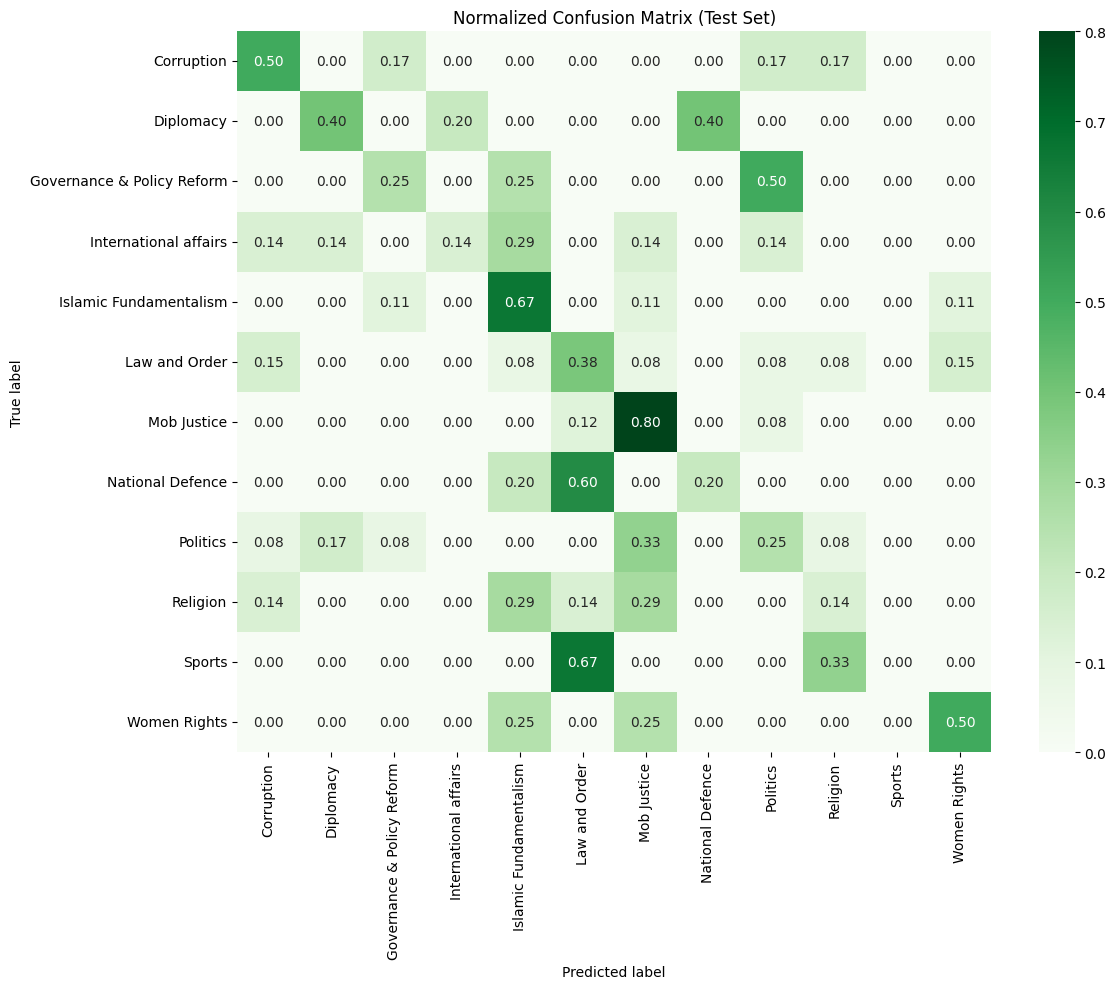

In [38]:
# Calculate metrics
print("\n--- Training set evaluation (on original training data) ---")
print(f"Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_train, y_train_pred))

print("\n--- Test set evaluation ---")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

# Generate confusion matrix for test set
print("\nGenerating confusion matrices...")

# Plot normalized confusion matrix for test set
plt.figure(figsize=(12, 10))
cm_test = confusion_matrix(y_test, y_test_pred)
cm_test_normalized = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_test_normalized, annot=True, fmt='.2f', cmap='Greens',
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Normalized Confusion Matrix (Test Set)')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix.png')  # Save the figure
plt.show()

In [39]:
# Save the model and vectorizer
print("\nSaving model and vectorizer...")
try:
    joblib.dump(model, '/content/drive/MyDrive/TechTalentAssignment/text_classification_model_T2.pkl')
    joblib.dump(tfidf_vectorizer, '/content/drive/MyDrive/TechTalentAssignment/tfidf_vectorizer.pkl')
    print("Model and vectorizer saved successfully!")
except Exception as e:
    print(f"Error saving model: {str(e)}")


Saving model and vectorizer...
Model and vectorizer saved successfully!


In [50]:
# Function for prediction with new text
def predict_topic(text, model=None, vectorizer=None):
    """
    Predict the topic of a given text.

    Args:
        text (str): The text to classify
        model: Optional pre-loaded model
        vectorizer: Optional pre-loaded vectorizer

    Returns:
        dict: Prediction results
    """
    # Load model and vectorizer if not provided
    if model is None or vectorizer is None:
        try:
            model = joblib.load('text_classification_model.pkl')
            vectorizer = joblib.load('tfidf_vectorizer.pkl')
        except Exception as e:
            return {"error": f"Could not load model or vectorizer: {str(e)}"}

    try:
        # Preprocess the text
        clean_text = preprocess_text(text)
        if not clean_text:
            return {"error": "Text is empty after preprocessing"}

        # Vectorize the text - IMPORTANT: use transform, not fit_transform
        text_tfidf = vectorizer.transform([clean_text])

        # Predict the topic
        prediction = model.predict(text_tfidf)[0]

        # Get prediction probabilities
        proba = model.predict_proba(text_tfidf)[0]

        # Find top 3 classes (or fewer if there are fewer classes)
        top_n = min(3, len(model.classes_))
        top_idx = proba.argsort()[-top_n:][::-1]
        top_classes = [model.classes_[i] for i in top_idx]
        top_probs = [proba[i] for i in top_idx]

        return {
            'predicted_topic': prediction,
            'top_topics': list(zip(top_classes, top_probs))
        }
    except Exception as e:
        return {"error": f"Prediction error: {str(e)}"}

In [52]:
if __name__ == "__main__":
    # Load the model and vectorizer once
    try:
        loaded_model = joblib.load('/content/drive/MyDrive/TechTalentAssignment/text_classification_model_T2.pkl')
        loaded_vectorizer = joblib.load('/content/drive/MyDrive/TechTalentAssignment/tfidf_vectorizer.pkl')

        # Test with sample text
        sample_text = "mob justice"
        prediction_result = predict_topic(sample_text, loaded_model, loaded_vectorizer)

        print("\nSample prediction:")
        print(f"Text: '{sample_text}'")
        if "error" in prediction_result:
            print(f"Error: {prediction_result['error']}")
        else:
            print(f"Predicted Topic: {prediction_result['predicted_topic']}")
            print("Top predictions:")
            for topic, prob in prediction_result['top_topics']:
                print(f"  {topic}: {prob:.4f}")
    except Exception as e:
        print(f"Error in demo prediction: {str(e)}")


Sample prediction:
Text: 'mob justice'
Predicted Topic: Law and Order
Top predictions:
  Law and Order: 0.2021
  Mob Justice: 0.1110
  Religion: 0.0895



Most important features for each class:
Class 'Corruption': জব ধর, লগঞ, রক, উপদ পর, কম, অর, ছড়, জব ছড়, উল, গঠন, পয়স, কফ, জব, দক, অভ
Class 'Diplomacy': shake, পর দর, delhi, general, islamophobia, indian army, বলল, indian, army, visit, issue, রত, اور, army chief, chief
Class 'Governance & Policy Reform': করব, টপ করব, দরক, basin, ইব, উল, শব, ইন, উত, interim, change, গনঅভ, সরক, লব, bangladesh islamist
Class 'International affairs': radical islamist, stopped, army, said, china, development, human, right, south, real, news, bangladesh army, pakistan, রত, india
Class 'Islamic Fundamentalism': death, two, concert, member, জশ, bangladeshi islamist, harm, হক, slam, bangladesh grip, grip, radical islamist, radical, gun, islamist
Class 'Law and Order': ধর ষন, কথ কর, justice, শহ, protest, বছ, যবস, narayanganj, কর, সকল, ঘর, police, আইন, journalist, clash
Class 'Mob Justice': রব, জনত, হব, last, ষক, ধর ষক, চল, অপর, যদ, এর, মব কর, মব এর, এই, মব মব, মব
Class 'National Defence': immigration, immigration

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Figure size 1200x800 with 0 Axes>

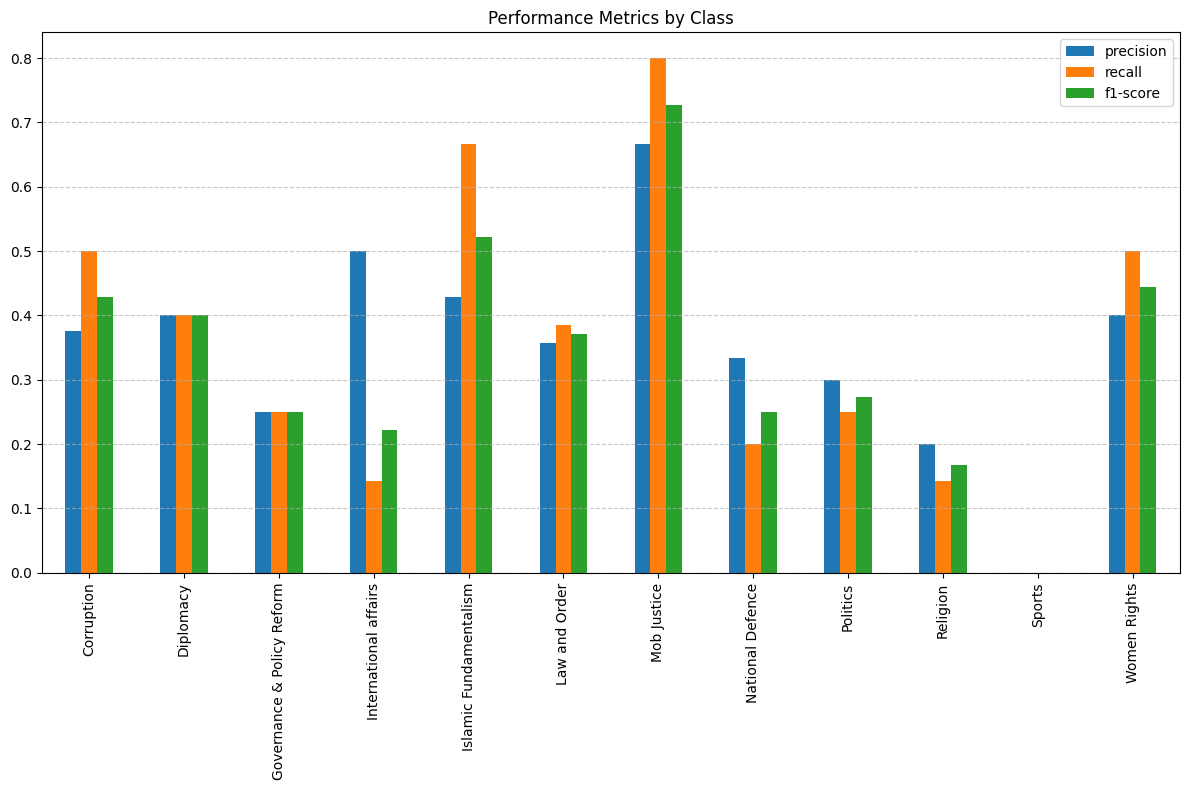


Detailed per-class metrics (sorted by F1-score):
                            precision    recall  f1-score  support
Sports                       0.000000  0.000000  0.000000     3.00
Religion                     0.200000  0.142857  0.166667     7.00
International affairs        0.500000  0.142857  0.222222     7.00
Governance & Policy Reform   0.250000  0.250000  0.250000     4.00
National Defence             0.333333  0.200000  0.250000     5.00
Politics                     0.300000  0.250000  0.272727    12.00
macro avg                    0.350893  0.353083  0.337835   100.00
Law and Order                0.357143  0.384615  0.370370    13.00
Diplomacy                    0.400000  0.400000  0.400000     5.00
weighted avg                 0.421833  0.450000  0.422864   100.00
Corruption                   0.375000  0.500000  0.428571     6.00
Women Rights                 0.400000  0.500000  0.444444     4.00
accuracy                     0.450000  0.450000  0.450000     0.45
Islamic Fund

<ipython-input-46-dfc3a2d1a020>:75: UserWarning: Glyph 2478 (\N{BENGALI LETTER MA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-46-dfc3a2d1a020>:75: UserWarning: Matplotlib currently does not support Bengali natively.
  plt.tight_layout()
<ipython-input-46-dfc3a2d1a020>:75: UserWarning: Glyph 2476 (\N{BENGALI LETTER BA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-46-dfc3a2d1a020>:75: UserWarning: Glyph 2447 (\N{BENGALI LETTER E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-46-dfc3a2d1a020>:75: UserWarning: Glyph 2439 (\N{BENGALI LETTER I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-46-dfc3a2d1a020>:75: UserWarning: Glyph 2480 (\N{BENGALI LETTER RA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-46-dfc3a2d1a020>:75: UserWarning: Glyph 2453 (\N{BENGALI LETTER KA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-46-dfc3a2d1a020>:75: UserWa

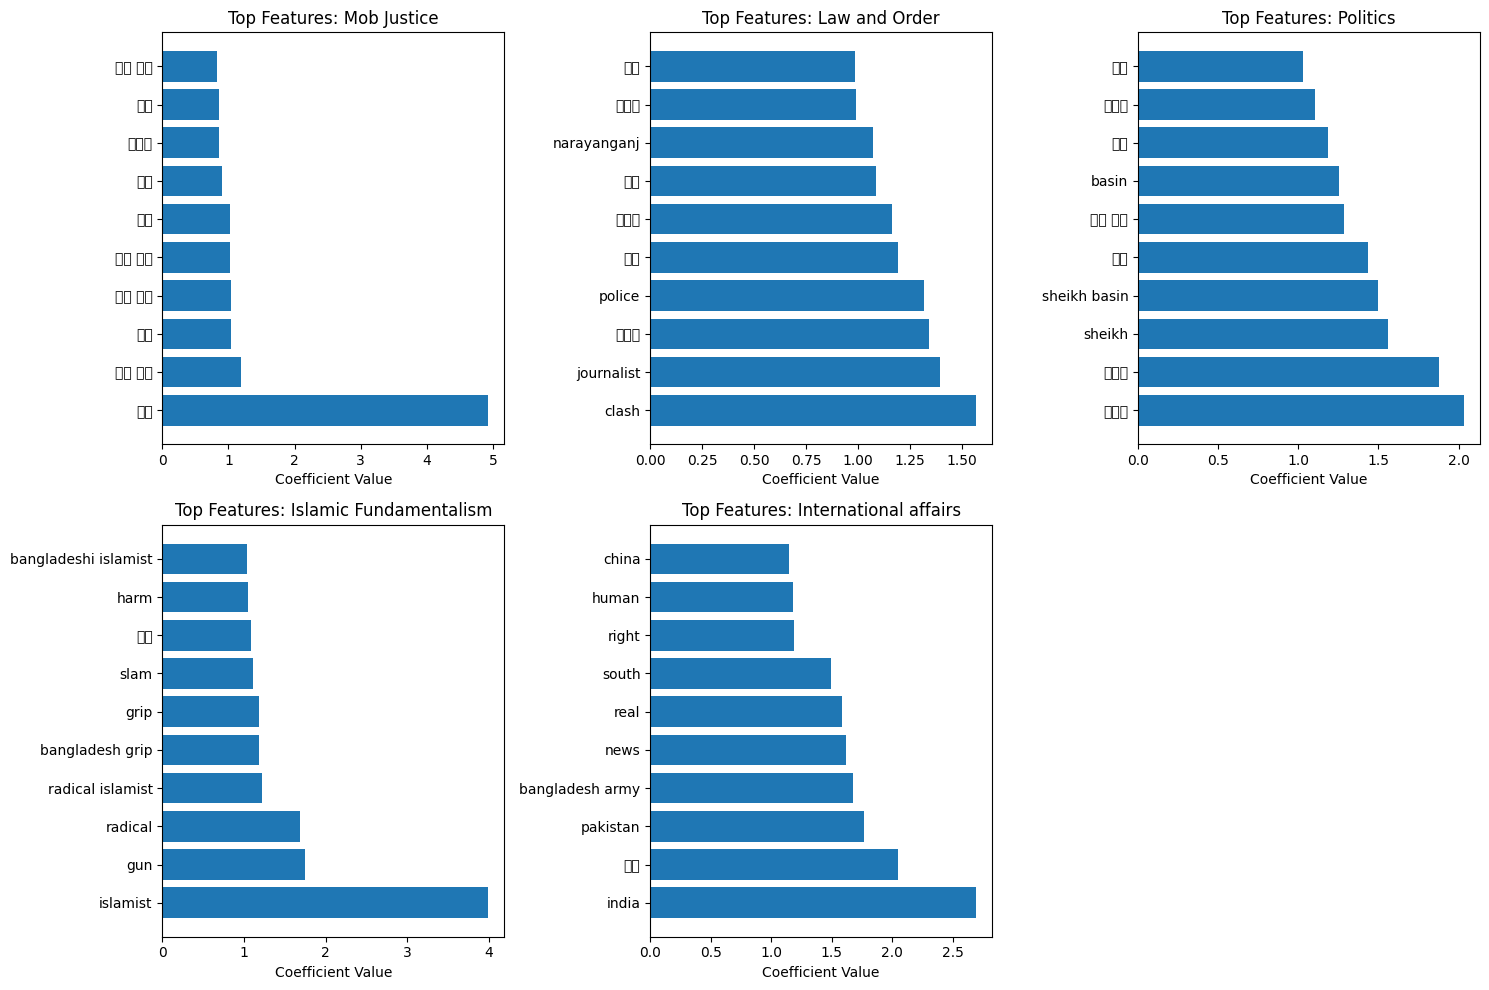


Sample prediction:
Text: 'Police arrested three individuals involved in corruption at the ministry'
Predicted Topic: Law and Order
Top 3 predictions:
  Law and Order: 0.2144
  Corruption: 0.1079
  Mob Justice: 0.1031


In [46]:
# Identify the most important features for each class
print("\nMost important features for each class:")
feature_names = tfidf_vectorizer.get_feature_names_out()

# Create a DataFrame to store feature importance for visualization
feature_importance_data = []

for i, class_label in enumerate(model.classes_):
    # Get top features with highest coefficients for this class
    top_features_idx = np.argsort(model.coef_[i])[-15:]
    top_features = [feature_names[idx] for idx in top_features_idx]
    top_coefficients = [model.coef_[i][idx] for idx in top_features_idx]

    # Add to the feature importance data
    for feature, coef in zip(top_features, top_coefficients):
        feature_importance_data.append({
            'Class': class_label,
            'Feature': feature,
            'Importance': coef
        })

    # Print top features for this class
    print(f"Class '{class_label}': {', '.join(top_features)}")

# Create a bar chart showing performance metrics per class
print("\nVisualizing per-class performance...")
class_report = classification_report(y_test, y_test_pred, output_dict=True)
class_df = pd.DataFrame(class_report).transpose()
metrics_df = class_df[['precision', 'recall', 'f1-score']].iloc[:-3]  # Remove avg/total rows

plt.figure(figsize=(12, 8))
metrics_df.plot(kind='bar', figsize=(12, 8))
plt.title('Performance Metrics by Class')
plt.xticks(rotation=90)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('class_performance.png')  # Save the figure
plt.show()

# Display detailed per-class metrics
print("\nDetailed per-class metrics (sorted by F1-score):")
print(class_df[['precision', 'recall', 'f1-score', 'support']].sort_values(by='f1-score'))

# Display class distribution comparison
print("\nClass counts comparison (original train vs. resampled train vs. test):")
original_train_counts = pd.Series(y_train).value_counts().sort_index()
resampled_train_counts = pd.Series(y_train_resampled).value_counts().sort_index()
test_counts = pd.Series(y_test).value_counts().sort_index()

comparison_df = pd.DataFrame({
    'Original Train': original_train_counts,
    'Resampled Train': resampled_train_counts,
    'Test': test_counts
}).fillna(0).astype(int)

print(comparison_df)

# Visualize top features for the most prevalent classes
top_classes = class_counts.index[:5]  # Top 5 classes
plt.figure(figsize=(15, 10))
for i, class_name in enumerate(top_classes):
    class_data = [item for item in feature_importance_data if item['Class'] == class_name]
    class_data = sorted(class_data, key=lambda x: x['Importance'], reverse=True)[:10]

    plt.subplot(2, 3, i+1)
    features = [item['Feature'] for item in class_data]
    importances = [item['Importance'] for item in class_data]

    y_pos = np.arange(len(features))
    plt.barh(y_pos, importances, align='center')
    plt.yticks(y_pos, features)
    plt.xlabel('Coefficient Value')
    plt.title(f"Top Features: {class_name}")

plt.tight_layout()
plt.savefig('top_features.png')  # Save the figure
plt.show()

# Function for prediction with new text
def predict_topic(text):
    # Preprocess the text
    clean_text = preprocess_text(text)
    # Vectorize the text
    text_tfidf = tfidf_vectorizer.transform([clean_text])
    # Predict the topic
    prediction = model.predict(text_tfidf)[0]
    # Get prediction probabilities
    proba = model.predict_proba(text_tfidf)[0]
    # Find top 3 classes
    top3_idx = proba.argsort()[-3:][::-1]
    top3_classes = [model.classes_[i] for i in top3_idx]
    top3_probs = [proba[i] for i in top3_idx]

    return {
        'predicted_topic': prediction,
        'top3_topics': list(zip(top3_classes, top3_probs))
    }

# Demo prediction with sample text
sample_text = "Police arrested three individuals involved in corruption at the ministry"
prediction_result = predict_topic(sample_text)
print("\nSample prediction:")
print(f"Text: '{sample_text}'")
print(f"Predicted Topic: {prediction_result['predicted_topic']}")
print("Top 3 predictions:")
for topic, prob in prediction_result['top3_topics']:
    print(f"  {topic}: {prob:.4f}")